Import some packages

In [235]:
from time import time 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random

random.seed( 20200228 ) #set a seed

Code for deﬁne a function for classic RK4 method

In [236]:
def oderk4(f, trange, y0, n):
    """ODERK4   Classical RK4 for y'=f(t,y)  where y,f are vectors

           call as
           [t,w] = oderk4(f,trange,y0,n)
           f        is the name of the function M-file for the RHS
           trange    are initial and final times (other times not used)
           y0       is the initial condition y(t0)=y0
           n        is the number of equal sized steps
           t        output time vector of length n+1
           w        output solution.  w[s,:] approx y[t[s]]
    """

    t0 = trange[0]  # initial time
    t1 = trange[-1]  # final time
    w = np.zeros((n + 1, len(y0)))  # make space
    t = np.zeros(n + 1)
    h = (t1 - t0) / n  # compute step size h

    t[0] = t0
    w[0, :] = y0  # initial condition

    for s in range(n):  # loop from t0 to t1
        k1 = h * f(t[s], w[s, :]).T
        k2 = h * f(t[s] + h / 2, w[s, :] + k1 / 2).T
        k3 = h * f(t[s] + h / 2, w[s, :] + k2 / 2).T
        k4 = h * f(t[s] + h, w[s, :] + k3).T
        w[s + 1, :] = w[s, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6  # take one step
        t[s + 1] = s * h + t0

    return t, w.T

Encode the problem in Equation 32 to deﬁne the function f(t,u) as nonlinear_osc(t, u)

In [237]:

def nonlinear_osc(t, u):

    dudt = np.zeros(2)

    dudt[0] = np.sin(u[0]) - u[1] + 8 + 42 * np.exp(-42*(t-42)**2)

    dudt[1] = 0.12 * (u[0] + 0.7 - 0.8 * u[1])

    return dudt 



Set some values

In [238]:
u0=[3,4]           #initial values
abs_tol = 1e-30    #absolute error tolerance
rel_tol = 1e-8     #relative error tolerance


Run three solvers and time the calculation for each solver

In [239]:
##RK45 solver(approximately equivalent to MATLAB's ode45 solver)
start_45 = time()
#run RK45 solver
sol_45 = solve_ivp(

    nonlinear_osc, [0, 100], u0, method="RK45", atol=abs_tol, rtol=rel_tol

)
#time calculation for RK45 solver
solve_time_45 = time() - start_45  

In [240]:
##BDF solver(approximately equivalent to MATLAB's ode15s solver)
start_bdf = time()
#run BDF solver
sol_bdf = solve_ivp(

    nonlinear_osc, [0, 100], u0, method="BDF", atol=abs_tol, rtol=rel_tol

)
#time calculation for BDF solver
solve_time_bdf = time() - start_bdf #time calculation

In [241]:
##RK4 solver
start_rk4 = time()
#run RK4 solver
t_rk4, sol_rk4 = oderk4(lambda t, u: nonlinear_osc(t, u), [0, 100], u0, 200)
#time calculation for RK4 solver
solve_time_rk4 = time() - start_rk4


Output time spent on calculation and the number of steps for each solver

In [242]:
print(

    "CPU time {:>10} {:>10} {:>10}\n {:>18.4f}  {:>9.4f}  {:>9.4f} ".format(

        "BDF", "RK45", "oderk4", solve_time_bdf, solve_time_45, solve_time_rk4

    )

)
#CPU time        BDF       RK45     oderk4
#             0.4391     0.0791     0.0100 


CPU time        BDF       RK45     oderk4
             0.4540     0.0777     0.0080 


Plots of approximate solution against time for each method

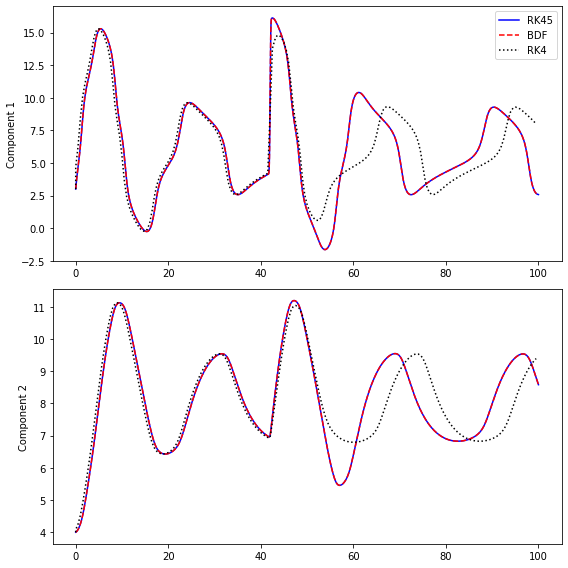

<Figure size 432x288 with 0 Axes>

In [243]:
fig, ax = plt.subplots(2,figsize=(8,8))
for i in range(2):
    
    ax[i].plot(sol_45.t, sol_45.y[i, :], "b-")
    
    ax[i].plot(sol_bdf.t, sol_bdf.y[i, :], "r--")

    ax[i].plot(t_rk4, sol_rk4[i, :], "k:")

    ax[i].set_ylabel("Component {}".format(i + 1))

ax[0].legend(["RK45", "BDF",  "RK4"])

plt.tight_layout()

plt.show()

plt.savefig('approx_sol.png', bbox_inches='tight')

In [244]:
##print out the approximate values
print (sol_45.y[:,-1])
print (sol_bdf.y[:,-1])
print (sol_rk4[:,-1])
#[2.57811303 8.58087885]
#[2.57811312 8.58087745]
#[7.99716266 9.39211953]
##the estimate of how accurate the results by RK45 and BDF
print (abs_tol + rel_tol *abs(sol_45.y[:,-1]))
print (abs_tol + rel_tol *abs(sol_bdf.y[:,-1]))
#[2.57811303e-08 8.58087885e-08]
#[2.57811312e-08 8.58087745e-08]

[2.57811303 8.58087885]
[2.57811312 8.58087745]
[7.99716266 9.39211953]
[2.57811303e-08 8.58087885e-08]
[2.57811312e-08 8.58087745e-08]


In [255]:
#the number of steps each solver took
print(sol_45.y.shape[1],sol_bdf.y.shape[1],sol_rk4.shape[1])
#570 2306 201

570 2306 201


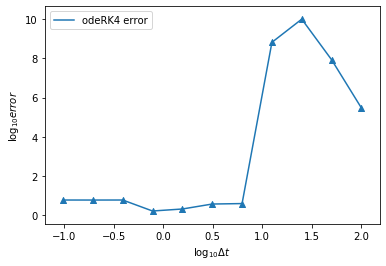

In [258]:
u_aux = np.zeros((2,11)) #define a matrix for approximations with other step size
logdt = np.zeros(11)     #log10(step size)
est_error = np.zeros(11) #error estimates
log_est_error=np.zeros(11)
for i in range(11):
    logdt[i]=np.log10(100/2**i)
    t_rk4, aux_sol_rk4 = oderk4(lambda t, u: nonlinear_osc(t, u), [0, 100], u0, 2**i)
    u_aux[:,i]=aux_sol_rk4[:,-1]
    est_error[i]=16/15*np.sqrt((u_aux[0,i]-sol_rk4[0,-1])**2+(u_aux[1,i]-sol_rk4[1,-1])**2)
    log_est_error[i]=np.log10(est_error[i])
    

plt.plot(logdt, log_est_error, label="odeRK4 error")
plt.scatter(logdt, log_est_error, marker='^')
plt.legend()
plt.xlabel('$\log_{10}{\Delta t}$')
plt.ylabel('$\log_{10}{error}$')
plt.show()

In [260]:
10**logdt

array([1.000000e+02, 5.000000e+01, 2.500000e+01, 1.250000e+01,
       6.250000e+00, 3.125000e+00, 1.562500e+00, 7.812500e-01,
       3.906250e-01, 1.953125e-01, 9.765625e-02])

In [261]:
log_est_error


array([ 5.46103894,  7.92633943, 10.00050173,  8.81758993,  0.58420282,
        0.56085503,  0.30719994,  0.20473308,  0.76576469,  0.7642084 ,
        0.76568655])

Overall, I will recommend RK45 (ode45 in Matlab) for this and similar problems. The reasons are following:
1. RK45 is the fastest in this case.
2. RK45 detected the stiﬀness pretty well.
3. The estimated error at t = 100 in RK45 method is pretty small, which means that RK45 method is accurate and eﬃcient.
4. Even though BDF can also detected the stiﬀness well and oﬀer accurate approximation, it takes more time to run. Compared with RK45 method, the higher cost per step for BDF method is not outweighed by the number of steps being reduced in our case. So RK45 will be more eﬃcient than BDF.